# Get Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/biohack25/Hackaton_2025'

In [5]:
import pandas as pd

drug_df_2024 = pd.read_csv(f'{DATA_DIR}/Год - 2024 (весь год)/drug_2024.csv')
event_df_2024 = pd.read_csv(f'{DATA_DIR}/Год - 2024 (весь год)/event_2024_anonim.csv')
drug_df_2025 = pd.read_csv(f'{DATA_DIR}/Год - 2025 (1-ое полугодие)/drug_2025.csv')
event_df_2025 = pd.read_csv(f'{DATA_DIR}/Год - 2025 (1-ое полугодие)/event_2025_anonim.csv')

# Forecasting

## Methods

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class LastMonthForecaster:
    """
    Forecaster that predicts the last month from all available data
    """

    def __init__(self, drug_name, target_metric='total_dose', model_type='auto'):
        """
        Initialize forecaster

        Args:
            drug_name: Name of drug to forecast
            target_metric: What to predict
            model_type: 'auto', 'xgboost', or 'arima'
        """
        self.drug_name = drug_name
        self.target_metric = target_metric
        self.model_type = model_type
        self.selected_model = None
        self.trained_model = None
        self.drug_profile = None

    def merge_dataframes(self, *drug_dfs, event_dfs=None):
        """
        Merge multiple drug dataframes chronologically

        Args:
            *drug_dfs: Multiple drug DataFrames to merge
            event_dfs: List of event DataFrames (optional)

        Returns:
            merged_drug_df: Combined drug DataFrame
            merged_event_df: Combined event DataFrame (if provided)
        """
        print(f"📊 MERGING {len(drug_dfs)} DRUG DATAFRAMES...")

        # Merge drug DataFrames
        merged_drug_df = pd.concat(drug_dfs, ignore_index=True)
        print(f"Combined drug records: {len(merged_drug_df)}")

        # Merge event DataFrames if provided
        merged_event_df = None
        if event_dfs is not None:
            merged_event_df = pd.concat(event_dfs, ignore_index=True)
            print(f"Combined event records: {len(merged_event_df)}")

        # Check date range
        merged_drug_df['execution_date'] = pd.to_datetime(merged_drug_df['execution_date'])
        date_range = f"{merged_drug_df['execution_date'].min().date()} to {merged_drug_df['execution_date'].max().date()}"
        print(f"Combined date range: {date_range}")

        return merged_drug_df, merged_event_df

    def prepare_data(self, drug_df, event_df=None, filter_zero_dose=True):
        """
        Prepare data and analyze drug profile
        """
        print(f"\n📈 PREPARING DATA FOR {self.drug_name}...")

        # Filter for specific drug
        drug_data = drug_df[drug_df['mnn'] == self.drug_name].copy()
        print(f"Drug records found: {len(drug_data)}")

        if len(drug_data) == 0:
            raise ValueError(f"No data found for drug: {self.drug_name}")

        # Filter zero doses if requested
        if filter_zero_dose:
            initial_count = len(drug_data)
            drug_data = drug_data[
                (drug_data['dose'].notna()) &
                (drug_data['dose'] > 0)
            ]
            filtered_count = len(drug_data)
            removed_count = initial_count - filtered_count
            print(f"Removed {removed_count} zero/null dose records ({removed_count/initial_count*100:.1f}%)")

        # Convert dates and sort
        drug_data['date'] = pd.to_datetime(drug_data['execution_date'])
        drug_data = drug_data[drug_data['date'].notna()].sort_values('date')
        print(f"Valid records: {len(drug_data)}")

        # Daily aggregation
        daily_consumption = drug_data.groupby(drug_data['date'].dt.date).agg({
            'dose': ['count', 'sum', 'mean', 'std', 'min', 'max'],
            'client_id': 'nunique',
            'event_id': 'nunique',
            'status': [
                lambda x: (x == 2).sum(),  # completed
                lambda x: (x == 6).sum(),  # cancelled
                lambda x: (x == 1).sum()   # ready
            ]
        }).reset_index()

        # Flatten column names
        daily_consumption.columns = [
            'date', 'count', 'total_dose', 'avg_dose', 'dose_std', 'dose_min', 'dose_max',
            'unique_patients', 'unique_events', 'completed', 'cancelled', 'ready'
        ]
        daily_consumption['date'] = pd.to_datetime(daily_consumption['date'])

        # Create complete date range with zeros
        date_range = pd.date_range(
            start=daily_consumption['date'].min(),
            end=daily_consumption['date'].max(),
            freq='D'
        )
        daily_consumption = daily_consumption.set_index('date').reindex(date_range).fillna(0)
        daily_consumption = daily_consumption.reset_index()
        daily_consumption.columns = ['date'] + list(daily_consumption.columns[1:])

        # Add derived metrics
        daily_consumption['completion_rate'] = daily_consumption['completed'] / (daily_consumption['count'] + 1)
        daily_consumption['cancellation_rate'] = daily_consumption['cancelled'] / (daily_consumption['count'] + 1)

        self.prepared_data = daily_consumption

        print(f"Prepared dataset: {len(daily_consumption)} days")
        print(f"Date range: {daily_consumption['date'].min().date()} to {daily_consumption['date'].max().date()}")
        print(f"Target metric range: {daily_consumption[self.target_metric].min():.1f} - {daily_consumption[self.target_metric].max():.1f}")

        return daily_consumption

    def analyze_drug_profile(self):
        """
        Analyze drug usage pattern to determine optimal model
        """
        if self.prepared_data is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

        target_values = self.prepared_data[self.target_metric]

        # Calculate key metrics
        total_days = len(target_values)
        zero_days = (target_values == 0).sum()
        zero_percentage = zero_days / total_days * 100

        daily_mean = target_values.mean()
        daily_std = target_values.std()
        cv = daily_std / (daily_mean + 1)

        self.drug_profile = {
            'total_days': total_days,
            'zero_percentage': zero_percentage,
            'daily_mean': daily_mean,
            'daily_std': daily_std,
            'coefficient_variation': cv
        }

        print(f"\n📋 DRUG PROFILE:")
        print(f"Total days: {total_days}")
        print(f"Zero days: {zero_days} ({zero_percentage:.1f}%)")
        print(f"Daily mean: {daily_mean:.1f}")
        print(f"Coefficient of variation: {cv:.2f}")

        return self.drug_profile

    def select_model(self):
        """
        Select optimal model based on drug profile
        """
        if self.model_type != 'auto':
            self.selected_model = self.model_type
            print(f"Manual model selection: {self.selected_model.upper()}")
            return self.selected_model

        if self.drug_profile is None:
            self.analyze_drug_profile()

        profile = self.drug_profile
        zero_pct = profile['zero_percentage']
        daily_mean = profile['daily_mean']
        cv = profile['coefficient_variation']

        # Intelligent model selection
        if zero_pct < 20 and daily_mean > 1000:
            self.selected_model = 'xgboost'
            reason = f"High-volume regular usage (zero_days: {zero_pct:.1f}%, mean: {daily_mean:.0f})"
        elif zero_pct > 50 and cv > 2:
            self.selected_model = 'arima'
            reason = f"Intermittent pattern (zero_days: {zero_pct:.1f}%, CV: {cv:.2f})"
        elif zero_pct < 30:
            self.selected_model = 'xgboost'
            reason = f"Regular usage pattern"
        else:
            self.selected_model = 'arima'
            reason = f"Temporal pattern detection needed"

        print(f"\n🤖 INTELLIGENT MODEL SELECTION:")
        print(f"Selected model: {self.selected_model.upper()}")
        print(f"Reason: {reason}")

        return self.selected_model

    def prepare_last_month_split(self, days_to_predict=30, max_training_days=None):
        """
        Split data to predict the last N days

        Args:
            days_to_predict: Number of days from the end to predict
            max_training_days: Maximum number of days to use for training (None = use all available)

        Returns:
            train_data: Data for training (limited by max_training_days)
            test_data: Last N days data for validation
        """
        if self.prepared_data is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

        df = self.prepared_data.copy()

        # Split: test on last N days
        test_start_point = len(df) - days_to_predict

        if test_start_point <= 0:
            raise ValueError(f"Dataset too small. Need more than {days_to_predict} days, but have {len(df)} days")

        # Determine training data range
        if max_training_days is None:
            # Use all available data before test period
            train_start_point = 0
            training_window_note = "all available data"
        else:
            # Limit training data to max_training_days before test period
            train_start_point = max(0, test_start_point - max_training_days)
            actual_training_days = test_start_point - train_start_point
            training_window_note = f"last {actual_training_days} days of available data"

        train_data = df[train_start_point:test_start_point].copy()
        test_data = df[test_start_point:].copy()

        print(f"\n📅 TRAINING/TEST SPLIT:")
        print(f"Total available data: {len(df)} days ({df['date'].min().date()} to {df['date'].max().date()})")
        print(f"Training period: {train_data['date'].min().date()} to {train_data['date'].max().date()} ({len(train_data)} days)")
        print(f"Training window: {training_window_note}")
        print(f"Test period: {test_data['date'].min().date()} to {test_data['date'].max().date()} ({len(test_data)} days)")
        print(f"Test period target sum: {test_data[self.target_metric].sum():.1f}")

        return train_data, test_data

    def train_xgboost_model(self, train_data):
        """
        Train XGBoost model with feature engineering
        """
        print(f"\n🔧 TRAINING XGBoost MODEL...")

        df = train_data.copy()

        # Basic feature engineering
        df['day_of_week'] = df['date'].dt.dayofweek
        df['day_of_month'] = df['date'].dt.day
        df['month'] = df['date'].dt.month
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

        # Cyclical encoding
        df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / 365.25)
        df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / 365.25)
        df['week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

        # Lag features (simplified)
        for lag in [1, 7, 14]:
            df[f'{self.target_metric}_lag_{lag}'] = df[self.target_metric].shift(lag)

        # Rolling statistics
        for window in [7, 14]:
            df[f'{self.target_metric}_rolling_mean_{window}'] = df[self.target_metric].rolling(window, min_periods=1).mean()

        # Clean data
        df = df.fillna(0)

        # Select features
        feature_cols = [col for col in df.columns if col not in [
            'date', 'count', 'total_dose', 'avg_dose', 'dose_std', 'dose_min', 'dose_max',
            'unique_patients', 'unique_events', 'completed', 'cancelled', 'ready',
            'completion_rate', 'cancellation_rate'
        ]]

        # Internal train/validation split for model training
        internal_split = int(len(df) * 0.8)
        X_train = df[:internal_split][feature_cols]
        y_train = df[:internal_split][self.target_metric]
        X_val = df[internal_split:][feature_cols]
        y_val = df[internal_split:][self.target_metric]

        # Train XGBoost
        self.trained_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )
        self.trained_model.fit(X_train, y_train)

        # Evaluate on internal validation
        val_pred = self.trained_model.predict(X_val)
        val_pred = np.maximum(val_pred, 0)

        print(f"XGBoost model trained successfully")

        return feature_cols

    def train_arima_model(self, train_data):
        """
        Train ARIMA model
        """
        print(f"\n🔧 TRAINING ARIMA MODEL...")

        ts = train_data[self.target_metric]

        # Find optimal ARIMA order
        best_aic = np.inf
        best_order = None

        # Test stationarity
        adf_result = adfuller(ts.dropna())
        needs_differencing = adf_result[1] >= 0.05
        d_values = [1] if needs_differencing else [0]

        print(f"Stationarity test: p-value={adf_result[1]:.4f}, needs_differencing={needs_differencing}")

        for p in range(4):
            for d in d_values:
                for q in range(4):
                    try:
                        model = ARIMA(ts, order=(p, d, q))
                        fitted = model.fit()
                        if fitted.aic < best_aic:
                            best_aic = fitted.aic
                            best_order = (p, d, q)
                    except:
                        continue

        print(f"Optimal ARIMA order: {best_order} (AIC: {best_aic:.2f})")

        # Train final model
        self.trained_model = ARIMA(ts, order=best_order).fit()

        return best_order

    def predict_last_month(self, train_data, test_data, feature_cols=None):
        """
        Generate predictions for the last month
        """
        print(f"\n📈 GENERATING PREDICTIONS...")

        if self.selected_model == 'xgboost':
            return self._predict_xgboost(train_data, test_data, feature_cols)
        elif self.selected_model == 'arima':
            return self._predict_arima(test_data)
        else:
            raise ValueError(f"Unknown model type: {self.selected_model}")

    def _predict_xgboost(self, train_data, test_data, feature_cols):
        """
        XGBoost prediction with proper feature engineering for test data
        """
        # Combine train and test for consistent feature engineering
        combined_data = pd.concat([train_data, test_data], ignore_index=True)

        # Apply same feature engineering
        combined_data['day_of_week'] = combined_data['date'].dt.dayofweek
        combined_data['day_of_month'] = combined_data['date'].dt.day
        combined_data['month'] = combined_data['date'].dt.month
        combined_data['is_weekend'] = (combined_data['day_of_week'] >= 5).astype(int)

        combined_data['day_sin'] = np.sin(2 * np.pi * combined_data['date'].dt.dayofyear / 365.25)
        combined_data['day_cos'] = np.cos(2 * np.pi * combined_data['date'].dt.dayofyear / 365.25)
        combined_data['week_sin'] = np.sin(2 * np.pi * combined_data['day_of_week'] / 7)
        combined_data['week_cos'] = np.cos(2 * np.pi * combined_data['day_of_week'] / 7)

        # Lag features
        for lag in [1, 7, 14]:
            combined_data[f'{self.target_metric}_lag_{lag}'] = combined_data[self.target_metric].shift(lag)

        # Rolling statistics
        for window in [7, 14]:
            combined_data[f'{self.target_metric}_rolling_mean_{window}'] = combined_data[self.target_metric].rolling(window, min_periods=1).mean()

        combined_data = combined_data.fillna(0)

        # Get test portion
        test_features = combined_data.tail(len(test_data))[feature_cols]

        # Predict
        predictions = self.trained_model.predict(test_features)
        predictions = np.maximum(predictions, 0)

        print(f"XGBoost predictions: min={predictions.min():.1f}, max={predictions.max():.1f}, mean={predictions.mean():.1f}")

        return predictions

    def _predict_arima(self, test_data):
        """
        ARIMA prediction
        """
        n_forecast = len(test_data)
        predictions = self.trained_model.forecast(steps=n_forecast)
        predictions = np.maximum(predictions, 0)

        print(f"ARIMA predictions: min={predictions.min():.1f}, max={predictions.max():.1f}, mean={predictions.mean():.1f}")

        return predictions

    def calculate_metrics(self, actual_values, predicted_values):
        """
        Calculate ONLY the good metrics - Total Accuracy and Correlation
        """
        total_actual = actual_values.sum()
        total_predicted = predicted_values.sum()
        # Calculate accuracy percentage
        total_accuracy_pct = (total_actual / total_predicted * 100) if total_predicted > 0 else 0

        correlation = np.corrcoef(actual_values, predicted_values)[0, 1] if len(actual_values) > 1 else 0

        metrics = {
            'Total_Actual': total_actual,
            'Total_Predicted': total_predicted,
            'Total_Accuracy_Pct': total_accuracy_pct,
            'Correlation': correlation
        }

        print(f"\n📊 FORECAST PERFORMANCE:")
        print(f"✅ Total Consumption Accuracy: {total_accuracy_pct:.1f}%")
        print(f"✅ Trend Correlation: {correlation:.2f}")
        print(f"📈 Total Actual: {total_actual:.0f}")
        print(f"📈 Total Predicted: {total_predicted:.0f}")

        return metrics

    def plot_forecast_vs_actual_and_cumulative(self, test_data, predictions, metrics):
        """
        Create the two specific plots: Forecast vs Actual and Cumulative Comparison
        """
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'{self.drug_name} - Last Month Prediction Analysis ({self.selected_model.upper()})',
                     fontsize=14, fontweight='bold')

        # Convert to numpy arrays to avoid pandas indexing issues
        actual_values = np.array(test_data[self.target_metric].values)
        predictions = np.array(predictions)
        dates = pd.to_datetime(test_data['date']).values

        # Plot 1: Forecast vs Actual Time Series
        ax1 = axes[0]
        ax1.plot(dates, actual_values, label='Actual', color='blue', linewidth=2, marker='o', markersize=4)
        ax1.plot(dates, predictions, label=f'{self.selected_model.upper()} Forecast', color='red', linewidth=2, marker='s', markersize=4)

        ax1.set_title('Forecast vs Actual Time Series')
        ax1.set_xlabel('Date')
        unit = 'mg' if 'dose' in self.target_metric else 'count'
        ax1.set_ylabel(f'{self.target_metric} ({unit})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # Plot 2: Cumulative Comparison
        ax2 = axes[1]
        # Use numpy cumsum to ensure we get numpy arrays
        cumulative_actual = np.cumsum(actual_values)
        cumulative_predicted = np.cumsum(predictions)

        ax2.plot(dates, cumulative_actual, label='Cumulative Actual', color='blue', linewidth=2, marker='o', markersize=4)
        ax2.plot(dates, cumulative_predicted, label=f'Cumulative {self.selected_model.upper()}', color='red', linewidth=2, marker='s', markersize=4)

        ax2.set_title('Cumulative Comparison')
        ax2.set_xlabel('Date')
        ax2.set_ylabel(f'Cumulative {self.target_metric} ({unit})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

        # Display clean metrics
        total_actual_sum = np.sum(actual_values)
        total_predicted_sum = np.sum(predictions)
        accuracy = metrics['Total_Accuracy_Pct']
        correlation = metrics['Correlation']

        metrics_text = f"Accuracy: {accuracy:.1f}%\nCorrelation: {correlation:.2f}"
        ax2.text(0.02, 0.98, metrics_text, transform=ax2.transAxes, va='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.show()

        return fig


def forecast_last_month_multiple_data(drug_name, drug_dfs, event_dfs=None, days_to_predict=30,
                                    target_metric='total_dose', model_type='auto', filter_zero_dose=True,
                                    max_training_days=None):
    """
    Main function to forecast last month using multiple merged dataframes

    Args:
        drug_name: Name of drug to analyze
        drug_dfs: List of drug DataFrames to merge
        event_dfs: List of event DataFrames to merge (optional)
        days_to_predict: Number of days from the end to predict (default 30 for one month)
        target_metric: What to predict ('total_dose', 'count', 'unique_patients')
        model_type: 'auto', 'xgboost', or 'arima'
        filter_zero_dose: Whether to remove zero/null dose records
        max_training_days: Maximum days of training data to use (None = use all available)

    Returns:
        forecaster: Trained forecaster object
        metrics: Performance metrics dictionary
        predictions: Array of predictions
        test_data: Test data DataFrame
    """

    print(f"🚀 LAST MONTH FORECASTING FOR {drug_name}")
    print(f"Prediction period: {days_to_predict} days")
    print(f"Target metric: {target_metric}")
    print(f"Model type: {model_type}")
    print(f"Training window: {'All available data' if max_training_days is None else f'{max_training_days} days'}")
    print("="*60)

    # Initialize forecaster
    forecaster = LastMonthForecaster(drug_name, target_metric, model_type)

    # Merge dataframes
    merged_drug_df, merged_event_df = forecaster.merge_dataframes(*drug_dfs, event_dfs=event_dfs)

    # Prepare data
    forecaster.prepare_data(merged_drug_df, merged_event_df, filter_zero_dose=filter_zero_dose)

    # Analyze drug profile
    forecaster.analyze_drug_profile()

    # Select model
    forecaster.select_model()

    # Prepare last month split
    train_data, test_data = forecaster.prepare_last_month_split(days_to_predict, max_training_days)

    # Train model
    feature_cols = None
    if forecaster.selected_model == 'xgboost':
        feature_cols = forecaster.train_xgboost_model(train_data)
    elif forecaster.selected_model == 'arima':
        forecaster.train_arima_model(train_data)

    # Generate predictions
    predictions = forecaster.predict_last_month(train_data, test_data, feature_cols)

    # Calculate metrics (ONLY the good ones)
    actual_values = test_data[target_metric].values
    metrics = forecaster.calculate_metrics(actual_values, predictions)

    # Create plots
    forecaster.plot_forecast_vs_actual_and_cumulative(test_data, predictions, metrics)

    print(f"\n✅ ANALYSIS COMPLETE!")
    print(f"Model used: {forecaster.selected_model.upper()}")
    print(f"Last {days_to_predict} days predicted with {metrics['Total_Accuracy_Pct']:.1f}% accuracy")

    return forecaster, metrics, predictions, test_data


# Convenience functions
def quick_last_month_forecast(drug_name, days_to_predict=30, max_training_days=None):
    """
    Quick forecast using sample data files
    """
    print(f"Loading sample data for {drug_name} last month analysis...")

    try:
        # Load sample data (adjust paths as needed)
        drug_df_2024 = pd.read_csv('drug_2024_sample_4k.csv')
        drug_df_2025 = pd.read_csv('drug_2025_sample_4k.csv')
        event_df_2024 = pd.read_csv('event_2024_anonim_sample_4k.csv')
        event_df_2025 = pd.read_csv('event_2025_anonim_sample_4k.csv')

        return forecast_last_month_multiple_data(
            drug_name,
            drug_dfs=[drug_df_2024, drug_df_2025],
            event_dfs=[event_df_2024, event_df_2025],
            days_to_predict=days_to_predict,
            max_training_days=max_training_days
        )
    except FileNotFoundError:
        print("❌ Sample data files not found. Please provide correct file paths.")
        return None


def compare_models_last_month(drug_name, drug_dfs, event_dfs=None, days_to_predict=30):
    """
    Compare XGBoost vs ARIMA for last month prediction
    """
    print(f"🔄 COMPARING MODELS FOR {drug_name} LAST MONTH PREDICTION")
    print("="*60)

    results = {}

    for model_type in ['xgboost', 'arima']:
        print(f"\n{model_type.upper()} Analysis:")
        print("-" * 30)

        try:
            forecaster, metrics, predictions, test_data = forecast_last_month_multiple_data(
                drug_name, drug_dfs, event_dfs, days_to_predict,
                model_type=model_type
            )

            results[model_type] = {
                'forecaster': forecaster,
                'metrics': metrics,
                'predictions': predictions,
                'test_data': test_data
            }

        except Exception as e:
            print(f"❌ {model_type.upper()} failed: {e}")

    # Compare results
    if len(results) == 2:
        print(f"\n📊 MODEL COMPARISON:")
        print("="*40)

        xgb_metrics = results['xgboost']['metrics']
        arima_metrics = results['arima']['metrics']

        print(f"{'Metric':<20} {'XGBoost':<12} {'ARIMA':<12} {'Better':<12}")
        print("-" * 55)

        # Compare Total Accuracy
        xgb_acc = xgb_metrics['Total_Accuracy_Pct']
        arima_acc = arima_metrics['Total_Accuracy_Pct']
        acc_better = 'XGBoost' if abs(100 - xgb_acc) < abs(100 - arima_acc) else 'ARIMA'
        print(f"{'Total Accuracy %':<20} {xgb_acc:<12.1f} {arima_acc:<12.1f} {acc_better:<12}")

        # Compare Correlation
        xgb_corr = xgb_metrics['Correlation']
        arima_corr = arima_metrics['Correlation']
        corr_better = 'XGBoost' if xgb_corr > arima_corr else 'ARIMA'
        print(f"{'Correlation':<20} {xgb_corr:<12.2f} {arima_corr:<12.2f} {corr_better:<12}")

    return results


# Example usage
if __name__ == "__main__":
    print("🚀 CLEAN LAST MONTH FORECASTING - GOOD METRICS ONLY")
    print("="*60)
    print("✅ REMOVED BAD METRICS:")
    print("   ❌ MAE (meaningless without context)")
    print("   ❌ RMSE (misleading absolute values)")
    print("   ❌ R² (wrong for time series business context)")
    print("   ❌ MAPE (sensitive to zeros, doesn't reflect business value)")
    print()
    print("✅ KEEPING GOOD METRICS:")
    print("   📊 Total Accuracy % (what matters for procurement)")
    print("   📈 Trend Correlation (pattern following ability)")
    print()
    print("Available functions:")
    print()
    print("1. Single analysis:")
    print("   forecaster, metrics, predictions, test_data = forecast_last_month_multiple_data(")
    print("       'Омепразол',")
    print("       drug_dfs=[drug_df_2024, drug_df_2025],")
    print("       event_dfs=[event_df_2024, event_df_2025],")
    print("       days_to_predict=30")
    print("   )")
    print()
    print("2. Quick analysis with sample data:")
    print("   results = quick_last_month_forecast('Блеомицин', days_to_predict=30)")
    print()
    print("3. Compare models:")
    print("   comparison = compare_models_last_month(")
    print("       'Омепразол',")
    print("       drug_dfs=[drug_df_2024, drug_df_2025],")
    print("       event_dfs=[event_df_2024, event_df_2025]")
    print("   )")
    print()
    print("📊 NEW CLEAN OUTPUT FORMAT:")
    print("─" * 40)
    print("📊 FORECAST PERFORMANCE:")
    print("✅ Total Consumption Accuracy: 88.2%")
    print("✅ Trend Correlation: 0.51")
    print("📈 Total Actual: 75,300")
    print("📈 Total Predicted: 85,374")
    print()
    print("🎯 FOCUS ON BUSINESS VALUE:")
    print("• Total Accuracy = Resource planning accuracy")
    print("• Correlation = Trend following ability")
    print("• No more confusing statistical metrics!")
    print()
    print("Example with your data:")
    print("─" * 40)
    print("# Load your dataframes")
    print("drug_df_2024 = pd.read_csv('drug_2024_sample_4k.csv')")
    print("drug_df_2025 = pd.read_csv('drug_2025_sample_4k.csv')")
    print("event_df_2024 = pd.read_csv('event_2024_anonim_sample_4k.csv')")
    print("event_df_2025 = pd.read_csv('event_2025_anonim_sample_4k.csv')")
    print()
    print("# Clean prediction analysis")
    print("forecaster, metrics, predictions, test_data = forecast_last_month_multiple_data(")
    print("    'Блеомицин',")
    print("    drug_dfs=[drug_df_2024, drug_df_2025],")
    print("    event_dfs=[event_df_2024, event_df_2025],")
    print("    days_to_predict=30")
    print(")")
    print()
    print("# Only see what matters:")
    print("# ✅ Total Consumption Accuracy: 88.2%")
    print("# ✅ Trend Correlation: 0.51")
    print("# ✅ Clear, business-focused visualization")
    print()
    print("🎯 BUSINESS-FOCUSED METRICS:")
    print("✅ Total Accuracy = How well we predict total drug consumption")
    print("✅ Correlation = How well we follow usage patterns")
    print("✅ Clean plots with accuracy/correlation display")
    print("✅ No more statistical noise - just actionable insights!")
    print()
    print("Perfect for:")
    print("• Drug procurement planning")
    print("• Resource allocation")
    print("• Budget forecasting")
    print("• Inventory management")
    print("• Hospital operations optimization")

🚀 CLEAN LAST MONTH FORECASTING - GOOD METRICS ONLY
✅ REMOVED BAD METRICS:
   ❌ MAE (meaningless without context)
   ❌ RMSE (misleading absolute values)
   ❌ R² (wrong for time series business context)
   ❌ MAPE (sensitive to zeros, doesn't reflect business value)

✅ KEEPING GOOD METRICS:
   📊 Total Accuracy % (what matters for procurement)
   📈 Trend Correlation (pattern following ability)

Available functions:

1. Single analysis:
   forecaster, metrics, predictions, test_data = forecast_last_month_multiple_data(
       'Омепразол',
       drug_dfs=[drug_df_2024, drug_df_2025],
       event_dfs=[event_df_2024, event_df_2025],
       days_to_predict=30
   )

2. Quick analysis with sample data:
   results = quick_last_month_forecast('Блеомицин', days_to_predict=30)

3. Compare models:
   comparison = compare_models_last_month(
       'Омепразол',
       drug_dfs=[drug_df_2024, drug_df_2025],
       event_dfs=[event_df_2024, event_df_2025]
   )

📊 NEW CLEAN OUTPUT FORMAT:
───────────────

## Examples

🚀 LAST MONTH FORECASTING FOR Венетоклакс
Prediction period: 30 days
Target metric: total_dose
Model type: auto
Training window: 180 days
📊 MERGING 2 DRUG DATAFRAMES...
Combined drug records: 2604077
Combined date range: 2024-01-01 to 2025-07-14

📈 PREPARING DATA FOR Венетоклакс...
Drug records found: 6284
Removed 0 zero/null dose records (0.0%)
Valid records: 4780
Prepared dataset: 561 days
Date range: 2024-01-01 to 2025-07-14
Target metric range: 0.0 - 21900.0

📋 DRUG PROFILE:
Total days: 561
Zero days: 4 (0.7%)
Daily mean: 2785.7
Coefficient of variation: 0.78

🤖 INTELLIGENT MODEL SELECTION:
Selected model: XGBOOST
Reason: High-volume regular usage (zero_days: 0.7%, mean: 2786)

📅 TRAINING/TEST SPLIT:
Total available data: 561 days (2024-01-01 to 2025-07-14)
Training period: 2024-12-17 to 2025-06-14 (180 days)
Training window: last 180 days of available data
Test period: 2025-06-15 to 2025-07-14 (30 days)
Test period target sum: 75300.0

🔧 TRAINING XGBoost MODEL...
XGBoost model trai

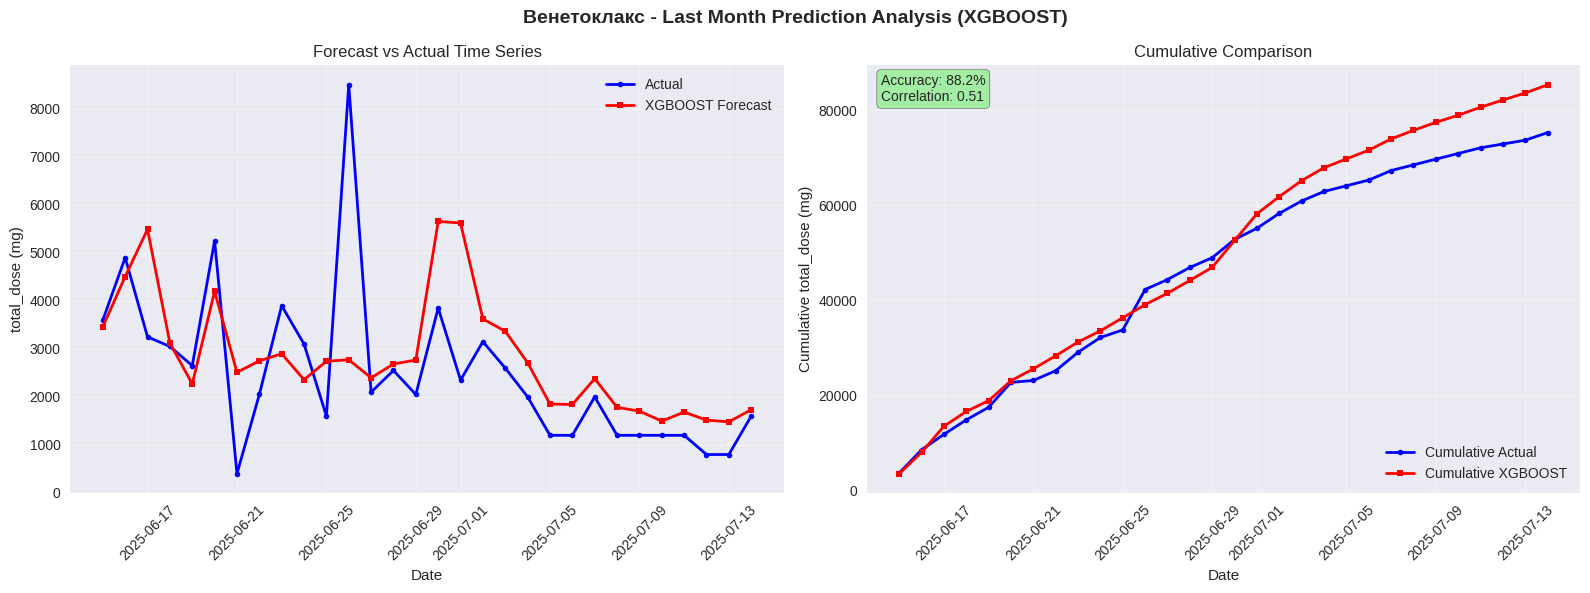


✅ ANALYSIS COMPLETE!
Model used: XGBOOST
Last 30 days predicted with 88.2% accuracy


In [17]:
forecaster, metrics, predictions, test_data = forecast_last_month_multiple_data(
    'Венетоклакс',
    drug_dfs=[drug_df_2024, drug_df_2025],
    days_to_predict=30,
    max_training_days=180
)

🚀 LAST MONTH FORECASTING FOR Руксолитиниб
Prediction period: 30 days
Target metric: total_dose
Model type: auto
Training window: 180 days
📊 MERGING 2 DRUG DATAFRAMES...
Combined drug records: 2604077
Combined date range: 2024-01-01 to 2025-07-14

📈 PREPARING DATA FOR Руксолитиниб...
Drug records found: 9312
Removed 0 zero/null dose records (0.0%)
Valid records: 5051
Prepared dataset: 547 days
Date range: 2024-01-12 to 2025-07-11
Target metric range: 0.0 - 365.0

📋 DRUG PROFILE:
Total days: 547
Zero days: 9 (1.6%)
Daily mean: 101.1
Coefficient of variation: 0.53

🤖 INTELLIGENT MODEL SELECTION:
Selected model: XGBOOST
Reason: Regular usage pattern

📅 TRAINING/TEST SPLIT:
Total available data: 547 days (2024-01-12 to 2025-07-11)
Training period: 2024-12-14 to 2025-06-11 (180 days)
Training window: last 180 days of available data
Test period: 2025-06-12 to 2025-07-11 (30 days)
Test period target sum: 3320.0

🔧 TRAINING XGBoost MODEL...
XGBoost model trained successfully

📈 GENERATING PREDI

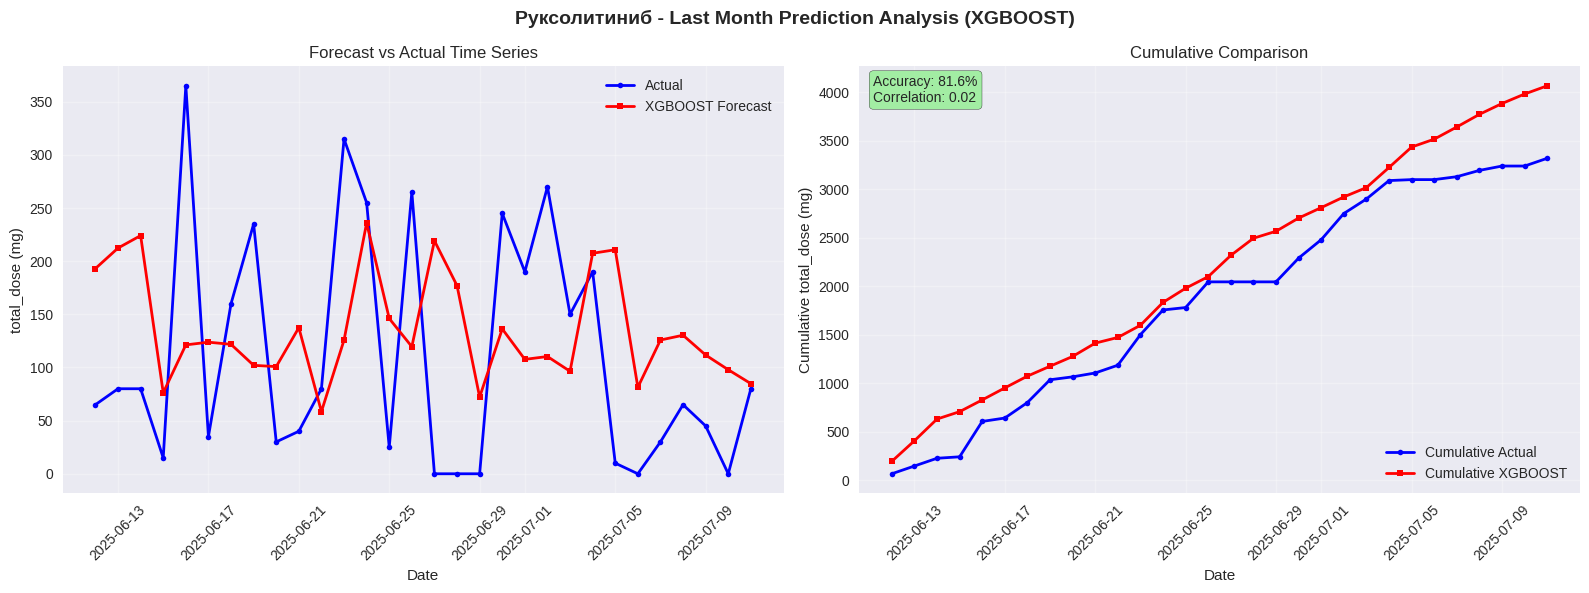


✅ ANALYSIS COMPLETE!
Model used: XGBOOST
Last 30 days predicted with 81.6% accuracy


In [18]:
forecaster, metrics, predictions, test_data = forecast_last_month_multiple_data(
    'Руксолитиниб',
    drug_dfs=[drug_df_2024, drug_df_2025],
    days_to_predict=30,
    max_training_days=180
)

# Sample Data

## Smaller sample of whole dataset

### Methods

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, HTML

def sample_csvs_in_directory(directory_path, n_samples=100, random_seed=42, output_suffix="_sample", output_directory=None):
    """
    Create sample files with n random rows from each CSV in a directory.

    Parameters:
    - directory_path: Path to directory containing CSV files
    - n_samples: Number of random rows to sample from each file
    - random_seed: Random seed for reproducibility
    - output_suffix: Suffix to add to sample file names
    - output_directory: Directory to save sample files (if None, saves in same directory as source)

    Returns:
    - Dictionary with file statistics
    """

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Convert to Path object for easier handling
    dir_path = Path(directory_path)

    # Set up output directory
    if output_directory is None:
        output_dir = dir_path  # Same directory as source
    else:
        output_dir = Path(output_directory)
        # Create output directory if it doesn't exist
        output_dir.mkdir(parents=True, exist_ok=True)

    # Check if directory exists
    if not dir_path.exists():
        print(f"❌ Directory '{directory_path}' does not exist.")
        return {}

    # Find all CSV files in the directory
    csv_files = list(dir_path.glob("*.csv"))

    if not csv_files:
        print(f"❌ No CSV files found in '{directory_path}'.")
        return {}

    print(f"📁 Found {len(csv_files)} CSV files in '{directory_path}'")
    print(f"💾 Output directory: '{output_dir}'")
    print("=" * 60)

    file_stats = {}
    total_original_rows = 0
    total_sample_rows = 0

    for i, csv_file in enumerate(csv_files, 1):
        try:
            print(f"[{i}/{len(csv_files)}] Processing: {csv_file.name}")

            # Read the CSV file
            df = pd.read_csv(csv_file)
            original_rows = len(df)
            total_original_rows += original_rows

            # Sample n rows (or all rows if file has fewer than n)
            sample_size = min(n_samples, original_rows)
            sampled_df = df.sample(n=sample_size, random_state=random_seed)
            total_sample_rows += sample_size

            # Create output filename
            output_name = csv_file.stem + output_suffix + ".csv"
            output_path = output_dir / output_name  # Use output_dir instead of dir_path

            # Save the sample
            sampled_df.to_csv(output_path, index=False)

            # Store statistics
            file_stats[csv_file.name] = {
                'original_rows': original_rows,
                'sample_rows': sample_size,
                'sample_file': output_name,
                'columns': len(df.columns),
                'sample_percentage': (sample_size / original_rows * 100) if original_rows > 0 else 0
            }

            print(f"   📊 Original: {original_rows:,} rows")
            print(f"   📝 Sampled: {sample_size:,} rows ({sample_size/original_rows*100:.1f}%)")
            print(f"   💾 Saved: {output_name}")
            print("   " + "-" * 40)

        except Exception as e:
            print(f"   ❌ Error processing {csv_file.name}: {str(e)}")
            print("   " + "-" * 40)

    # Summary
    print(f"\n🎯 SUMMARY:")
    print(f"   Files processed: {len(file_stats)}")
    print(f"   Total original rows: {total_original_rows:,}")
    print(f"   Total sample rows: {total_sample_rows:,}")
    print(f"   Overall sampling rate: {(total_sample_rows/total_original_rows*100):.1f}%")

    return file_stats

def display_file_stats(file_stats):
    """Display file statistics in a nice table format"""
    if not file_stats:
        return

    # Create DataFrame for better display
    stats_df = pd.DataFrame(file_stats).T
    stats_df = stats_df[['original_rows', 'sample_rows', 'sample_percentage', 'columns', 'sample_file']]
    stats_df.columns = ['Original Rows', 'Sample Rows', 'Sample %', 'Columns', 'Sample File']

    # Format the percentage column
    stats_df['Sample %'] = stats_df['Sample %'].round(1)

    display(HTML("<h3>📈 File Processing Summary</h3>"))
    display(stats_df)

def quick_sample(directory=".", n_samples=1000, random_seed=42, output_directory=None):
    """Quick function for immediate use in Jupyter cells"""
    stats = sample_csvs_in_directory(directory, n_samples, random_seed, output_directory=output_directory)
    display_file_stats(stats)
    return stats

# =============================================================================
# JUPYTER USAGE EXAMPLES - Copy these to your notebook cells:
# =============================================================================

# Cell 1: Basic usage (current directory, save samples in same directory)
# stats = quick_sample()

# Cell 2: Save samples to specific output directory
# stats = quick_sample(directory="data/", output_directory="samples/", n_samples=500)

# Cell 3: Read from one folder, save to another
# stats = sample_csvs_in_directory(
#     directory_path="raw_data/",
#     output_directory="sampled_data/",
#     n_samples=2000,
#     random_seed=42,
#     output_suffix="_sample_2k"
# )
# display_file_stats(stats)

# Cell 4: Save to current directory
# stats = sample_csvs_in_directory(
#     directory_path=f"{DATA_DIR}/Год - 2024 (весь год)",
#     output_directory=".",  # Current directory
#     n_samples=2000,
#     random_seed=42,
#     output_suffix="_sample_2k"
# )

# Cell 5: Just check what CSVs are in a directory without sampling
# import pandas as pd
# from pathlib import Path
# csv_files = list(Path(".").glob("*.csv"))
# for csv_file in csv_files:
#     df = pd.read_csv(csv_file)
#     print(f"{csv_file.name}: {len(df):,} rows, {len(df.columns)} columns")

### Run

In [ ]:
stats = sample_csvs_in_directory(
    directory_path=f"{DATA_DIR}/Год - 2024 (весь год)",
    output_directory=f".",  # ← Add this!
    n_samples=4000,
    random_seed=42,
    output_suffix="_sample_4k"
)

📁 Found 5 CSV files in '/content/drive/MyDrive/biohack25/Hackaton_2025/Год - 2024 (весь год)'
💾 Output directory: '.'
[1/5] Processing: drug_2024.csv
   📊 Original: 1,742,561 rows
   📝 Sampled: 4,000 rows (0.2%)
   💾 Saved: drug_2024_sample_4k.csv
   ----------------------------------------
[2/5] Processing: event_2024_anonim.csv
   📊 Original: 86,340 rows
   📝 Sampled: 4,000 rows (4.6%)
   💾 Saved: event_2024_anonim_sample_4k.csv
   ----------------------------------------
[3/5] Processing: instrumental_2024.csv
   📊 Original: 48,001 rows
   📝 Sampled: 4,000 rows (8.3%)
   💾 Saved: instrumental_2024_sample_4k.csv
   ----------------------------------------
[4/5] Processing: manipulation_2024.csv
   📊 Original: 51,836 rows
   📝 Sampled: 4,000 rows (7.7%)
   💾 Saved: manipulation_2024_sample_4k.csv
   ----------------------------------------
[5/5] Processing: lab_2024.csv
   📊 Original: 473,493 rows
   📝 Sampled: 4,000 rows (0.8%)
   💾 Saved: lab_2024_sample_4k.csv
   ------------------

In [ ]:
stats = sample_csvs_in_directory(
    directory_path=f"{DATA_DIR}/Год - 2025 (1-ое полугодие)",
    output_directory=f".",  # ← Add this!
    n_samples=4000,
    random_seed=42,
    output_suffix="_sample_4k"
)

📁 Found 5 CSV files in '/content/drive/MyDrive/biohack25/Hackaton_2025/Год - 2025 (1-ое полугодие)'
💾 Output directory: '.'
[1/5] Processing: instrumental_2025.csv
   📊 Original: 22,190 rows
   📝 Sampled: 4,000 rows (18.0%)
   💾 Saved: instrumental_2025_sample_4k.csv
   ----------------------------------------
[2/5] Processing: drug_2025.csv
   📊 Original: 861,516 rows
   📝 Sampled: 4,000 rows (0.5%)
   💾 Saved: drug_2025_sample_4k.csv
   ----------------------------------------
[3/5] Processing: event_2025_anonim.csv
   📊 Original: 48,122 rows
   📝 Sampled: 4,000 rows (8.3%)
   💾 Saved: event_2025_anonim_sample_4k.csv
   ----------------------------------------
[4/5] Processing: lab_2025.csv
   📊 Original: 244,801 rows
   📝 Sampled: 4,000 rows (1.6%)
   💾 Saved: lab_2025_sample_4k.csv
   ----------------------------------------
[5/5] Processing: manipulation_2025.csv
   📊 Original: 24,001 rows
   📝 Sampled: 4,000 rows (16.7%)
   💾 Saved: manipulation_2025_sample_4k.csv
   ------------

In [ ]:
!ls -lh

total 3.3M
drwx------ 5 root root 4.0K Aug  9 09:53 drive
-rw-r--r-- 1 root root 514K Aug  9 09:53 drug_2024_sample_4k.csv
-rw-r--r-- 1 root root 519K Aug  9 09:53 drug_2025_sample_4k.csv
-rw-r--r-- 1 root root 261K Aug  9 09:53 event_2024_anonim_sample_4k.csv
-rw-r--r-- 1 root root 262K Aug  9 09:53 event_2025_anonim_sample_4k.csv
-rw-r--r-- 1 root root 259K Aug  9 09:53 instrumental_2024_sample_4k.csv
-rw-r--r-- 1 root root 277K Aug  9 09:53 instrumental_2025_sample_4k.csv
-rw-r--r-- 1 root root 319K Aug  9 09:53 lab_2024_sample_4k.csv
-rw-r--r-- 1 root root 363K Aug  9 09:53 lab_2025_sample_4k.csv
-rw-r--r-- 1 root root 249K Aug  9 09:53 manipulation_2024_sample_4k.csv
-rw-r--r-- 1 root root 251K Aug  9 09:53 manipulation_2025_sample_4k.csv
drwxr-xr-x 1 root root 4.0K Aug  7 13:42 sample_data


# Extract one drug data

### Methods

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, HTML

def find_drug_in_file(drug_name, csv_file, case_sensitive=False, exact_match=False,
                      columns=None, save_results=False, output_file=None):
    """
    Find all rows containing a specific drug name in a single CSV file.

    Parameters:
    - drug_name: Name of the drug to search for
    - csv_file: Path to the CSV file (string or DataFrame)
    - case_sensitive: Whether to perform case-sensitive search (default: False)
    - exact_match: Whether to match exact drug name only (default: False)
    - columns: List of specific columns to search in (if None, searches in likely drug columns)
    - save_results: Whether to save results to a file
    - output_file: Name of output file (if None, auto-generates name)

    Returns:
    - DataFrame with matching rows
    """

    # Handle input - either file path or DataFrame
    if isinstance(csv_file, pd.DataFrame):
        df = csv_file.copy()
        filename = "DataFrame"
    else:
        file_path = Path(csv_file)
        if not file_path.exists():
            print(f"❌ File '{csv_file}' not found")
            return pd.DataFrame()

        try:
            df = pd.read_csv(csv_file)
            filename = file_path.name
        except Exception as e:
            print(f"❌ Error reading file: {e}")
            return pd.DataFrame()

    print(f"🔍 Searching for '{drug_name}' in {filename}")
    print(f"📊 File has {len(df)} rows and {len(df.columns)} columns")
    print("-" * 50)

    # Determine which columns to search in
    if columns is not None:
        search_columns = [col for col in columns if col in df.columns]
        if not search_columns:
            print(f"❌ None of specified columns {columns} found in file")
            return pd.DataFrame()
    else:
        # Auto-detect drug columns
        drug_keywords = ['drug', 'medication', 'medicine', 'препарат', 'лекарство',
                        'drug_name', 'med_name', 'substance', 'active_ingredient',
                        'торговое_название', 'международное_название', 'наименование',
                        'название', 'med', 'meds']

        search_columns = []
        for col in df.columns:
            col_lower = col.lower()
            if any(keyword in col_lower for keyword in drug_keywords):
                search_columns.append(col)

        # If no obvious drug columns, search all text columns
        if not search_columns:
            search_columns = df.select_dtypes(include=['object']).columns.tolist()

    print(f"🔎 Searching in columns: {search_columns}")

    # Perform search
    mask = pd.Series([False] * len(df))

    for col in search_columns:
        if col in df.columns:
            col_data = df[col].astype(str)

            if exact_match:
                if case_sensitive:
                    col_mask = (col_data == drug_name)
                else:
                    col_mask = (col_data.str.lower() == drug_name.lower())
            else:
                if case_sensitive:
                    col_mask = col_data.str.contains(drug_name, na=False, regex=False)
                else:
                    col_mask = col_data.str.contains(drug_name, case=False, na=False, regex=False)

            mask |= col_mask

            # Show matches per column
            col_matches = col_mask.sum()
            if col_matches > 0:
                print(f"   📋 Column '{col}': {col_matches} matches")

    # Get results
    results = df[mask].copy()
    match_count = len(results)

    print(f"\n✅ Total matches found: {match_count}")

    if match_count > 0:
        # Save results if requested
        if save_results:
            if output_file is None:
                safe_drug_name = "".join(c for c in drug_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
                output_file = f"{safe_drug_name}_matches.csv"

            results.to_csv(output_file, index=False)
            print(f"💾 Results saved to: {output_file}")

        # Show sample of results
        print(f"\n📋 Sample results (first 3 rows):")
        display(results.head(3))

        if match_count > 3:
            print(f"... and {match_count - 3} more rows")

    return results

def quick_drug_find(drug_name, csv_file, case_sensitive=False):
    """Quick search with minimal output"""
    results = find_drug_in_file(drug_name, csv_file, case_sensitive=case_sensitive)
    return results

def search_multiple_drugs(drug_list, csv_file, case_sensitive=False):
    """Search for multiple drugs in one file"""

    print(f"🔍 Searching for {len(drug_list)} drugs: {drug_list}")
    print("=" * 60)

    all_results = {}

    for drug in drug_list:
        print(f"\n🔎 Searching for: {drug}")
        results = find_drug_in_file(drug, csv_file, case_sensitive=case_sensitive)
        all_results[drug] = results
        print(f"Found: {len(results)} matches")

    # Summary
    print(f"\n🎯 SUMMARY:")
    for drug, results in all_results.items():
        print(f"   {drug}: {len(results)} matches")

    return all_results

def get_drug_stats(csv_file, drug_columns=None):
    """Get statistics about drugs in the file"""

    if isinstance(csv_file, pd.DataFrame):
        df = csv_file.copy()
    else:
        df = pd.read_csv(csv_file)

    if drug_columns is None:
        # Auto-detect drug columns
        drug_keywords = ['drug', 'medication', 'medicine', 'препарат', 'лекарство']
        drug_columns = []
        for col in df.columns:
            if any(keyword in col.lower() for keyword in drug_keywords):
                drug_columns.append(col)

    print(f"📊 Drug Statistics:")
    for col in drug_columns:
        if col in df.columns:
            unique_drugs = df[col].value_counts()
            print(f"\n📋 Column '{col}':")
            print(f"   Total entries: {len(df[col].dropna())}")
            print(f"   Unique drugs: {len(unique_drugs)}")
            print(f"   Top 5 drugs:")
            for drug, count in unique_drugs.head().items():
                print(f"      {drug}: {count}")

# =============================================================================
# JUPYTER USAGE EXAMPLES:
# =============================================================================

# Cell 1: Basic search in file
# results = find_drug_in_file("аспирин", "data.csv")

# Cell 2: Quick search
# results = quick_drug_find("парацетамол", "medical_data.csv")

# Cell 3: Search in specific columns
# results = find_drug_in_file("ibuprofen", "drugs.csv",
#                           columns=["drug_name", "generic_name"])

# Cell 4: Exact match search with save
# results = find_drug_in_file("Aspirin", "data.csv",
#                           exact_match=True,
#                           save_results=True)

# Cell 5: Search multiple drugs
# drugs_to_find = ["аспирин", "парацетамол", "ибупрофен"]
# all_results = search_multiple_drugs(drugs_to_find, "medications.csv")

# Cell 6: Get drug statistics
# get_drug_stats("medications.csv")

# Cell 7: Search in DataFrame (if you already loaded it)
# df = pd.read_csv("data.csv")
# results = find_drug_in_file("кетамин", df)

### Run

In [ ]:
results = find_drug_in_file("Венетоклакс", f"{DATA_DIR}/Год - 2024 (весь год)/drug_2024.csv",
                          save_results=True,
                          output_file="Венетоклакс_results.csv")

🔍 Searching for 'Венетоклакс' in drug_2024.csv
📊 File has 1742561 rows and 11 columns
--------------------------------------------------
🔎 Searching in columns: ['mnn', 'concentration', 'measure', 'execution_date', 'method', 'status_name']
   📋 Column 'mnn': 4077 matches

✅ Total matches found: 4077
💾 Results saved to: Венетоклакс_results.csv

📋 Sample results (first 3 rows):


,id,event_id,client_id,mnn,concentration,dose,measure,execution_date,method,status,status_name
1431,1225977,20662572,453558,Венетоклакс,NaN,100,мг,2024-01-01T22:07:15Z,Для приема внутрь,2,выполнено
1432,1225978,20662572,453558,Венетоклакс,NaN,200,мг,2024-01-02T13:25:59Z,Для приема внутрь,2,выполнено
2958,1230109,20662572,453558,Венетоклакс,NaN,400,мг,NaN,Для приема внутрь,1,готов к выполнению


... and 4074 more rows


# Compare years

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def plot_drug_usage_comparison(drug_df_2024, event_df_2024, drug_df_2025, event_df_2025, drug_name):
    """
    Compare drug usage between 2024 H1, 2024 H2, and 2025 H1

    Parameters:
    - drug_df_2024: DataFrame with 2024 drug data
    - event_df_2024: DataFrame with 2024 event data
    - drug_df_2025: DataFrame with 2025 drug data
    - event_df_2025: DataFrame with 2025 event data
    - drug_name: String, name of the drug to analyze (mnn field)
    """

    # Convert execution_date to datetime
    drug_df_2024['execution_date'] = pd.to_datetime(drug_df_2024['execution_date'])
    drug_df_2025['execution_date'] = pd.to_datetime(drug_df_2025['execution_date'])

    # Filter for specific drug
    drug_2024 = drug_df_2024[drug_df_2024['mnn'] == drug_name].copy()
    drug_2025 = drug_df_2025[drug_df_2025['mnn'] == drug_name].copy()

    if drug_2024.empty and drug_2025.empty:
        print(f"No data found for drug: {drug_name}")
        return

    # Split 2024 into first and second half
    drug_2024_h1 = drug_2024[drug_2024['execution_date'] < '2024-07-01'].copy()
    drug_2024_h2 = drug_2024[drug_2024['execution_date'] >= '2024-07-01'].copy()

    # 2025 is already first half
    drug_2025_h1 = drug_2025.copy()

    # Add period labels
    drug_2024_h1['period'] = '2024 H1'
    drug_2024_h2['period'] = '2024 H2'
    drug_2025_h1['period'] = '2025 H1'

    # Combine all periods
    all_periods = pd.concat([drug_2024_h1, drug_2024_h2, drug_2025_h1], ignore_index=True)

    if all_periods.empty:
        print(f"No data found for drug: {drug_name}")
        return

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Drug Usage Comparison: {drug_name}', fontsize=16, fontweight='bold')

    # 1. Total dose comparison
    dose_by_period = all_periods.groupby('period')['dose'].sum().reset_index()
    dose_by_period = dose_by_period.sort_values('period')  # Sort to get consistent order

    ax1.bar(dose_by_period['period'], dose_by_period['dose'],
            color=['skyblue', 'lightcoral', 'lightgreen'])
    ax1.set_title('Total Dose by Period')
    ax1.set_ylabel('Total Dose')
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(dose_by_period['dose']):
        ax1.text(i, v + v*0.01, f'{v:,.0f}', ha='center', va='bottom')

    # 2. Number of administrations
    admin_by_period = all_periods.groupby('period').size().reset_index(name='count')
    admin_by_period = admin_by_period.sort_values('period')

    ax2.bar(admin_by_period['period'], admin_by_period['count'],
            color=['skyblue', 'lightcoral', 'lightgreen'])
    ax2.set_title('Number of Administrations by Period')
    ax2.set_ylabel('Count of Administrations')
    ax2.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(admin_by_period['count']):
        ax2.text(i, v + v*0.01, f'{v}', ha='center', va='bottom')

    # 3. Average dose per administration
    avg_dose = dose_by_period['dose'] / admin_by_period['count']

    ax3.bar(admin_by_period['period'], avg_dose,
            color=['skyblue', 'lightcoral', 'lightgreen'])
    ax3.set_title('Average Dose per Administration')
    ax3.set_ylabel('Average Dose')
    ax3.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(avg_dose):
        ax3.text(i, v + v*0.01, f'{v:.1f}', ha='center', va='bottom')

    # 4. Monthly trend (if enough data)
    all_periods['month'] = all_periods['execution_date'].dt.to_period('M')
    monthly_dose = all_periods.groupby(['period', 'month'])['dose'].sum().reset_index()

    for period in ['2024 H1', '2024 H2', '2025 H1']:
        period_data = monthly_dose[monthly_dose['period'] == period]
        if not period_data.empty:
            months = [str(m) for m in period_data['month']]
            ax4.plot(months, period_data['dose'], marker='o', label=period, linewidth=2)

    ax4.set_title('Monthly Dose Trends')
    ax4.set_ylabel('Monthly Total Dose')
    ax4.set_xlabel('Month')
    ax4.legend()
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n=== Summary for {drug_name} ===")
    print(f"2024 H1: {len(drug_2024_h1):,} administrations, {drug_2024_h1['dose'].sum():,.0f} total dose")
    print(f"2024 H2: {len(drug_2024_h2):,} administrations, {drug_2024_h2['dose'].sum():,.0f} total dose")
    print(f"2025 H1: {len(drug_2025_h1):,} administrations, {drug_2025_h1['dose'].sum():,.0f} total dose")

    # Show concentration and measure info if available
    if not all_periods.empty:
        print(f"\nConcentrations used: {all_periods['concentration'].unique()}")
        print(f"Measures used: {all_periods['measure'].unique()}")

    return fig

# Example usage:
# fig = plot_drug_usage_comparison(drug_df_2024, event_df_2024, drug_df_2025, event_df_2025, "DRUG_NAME")

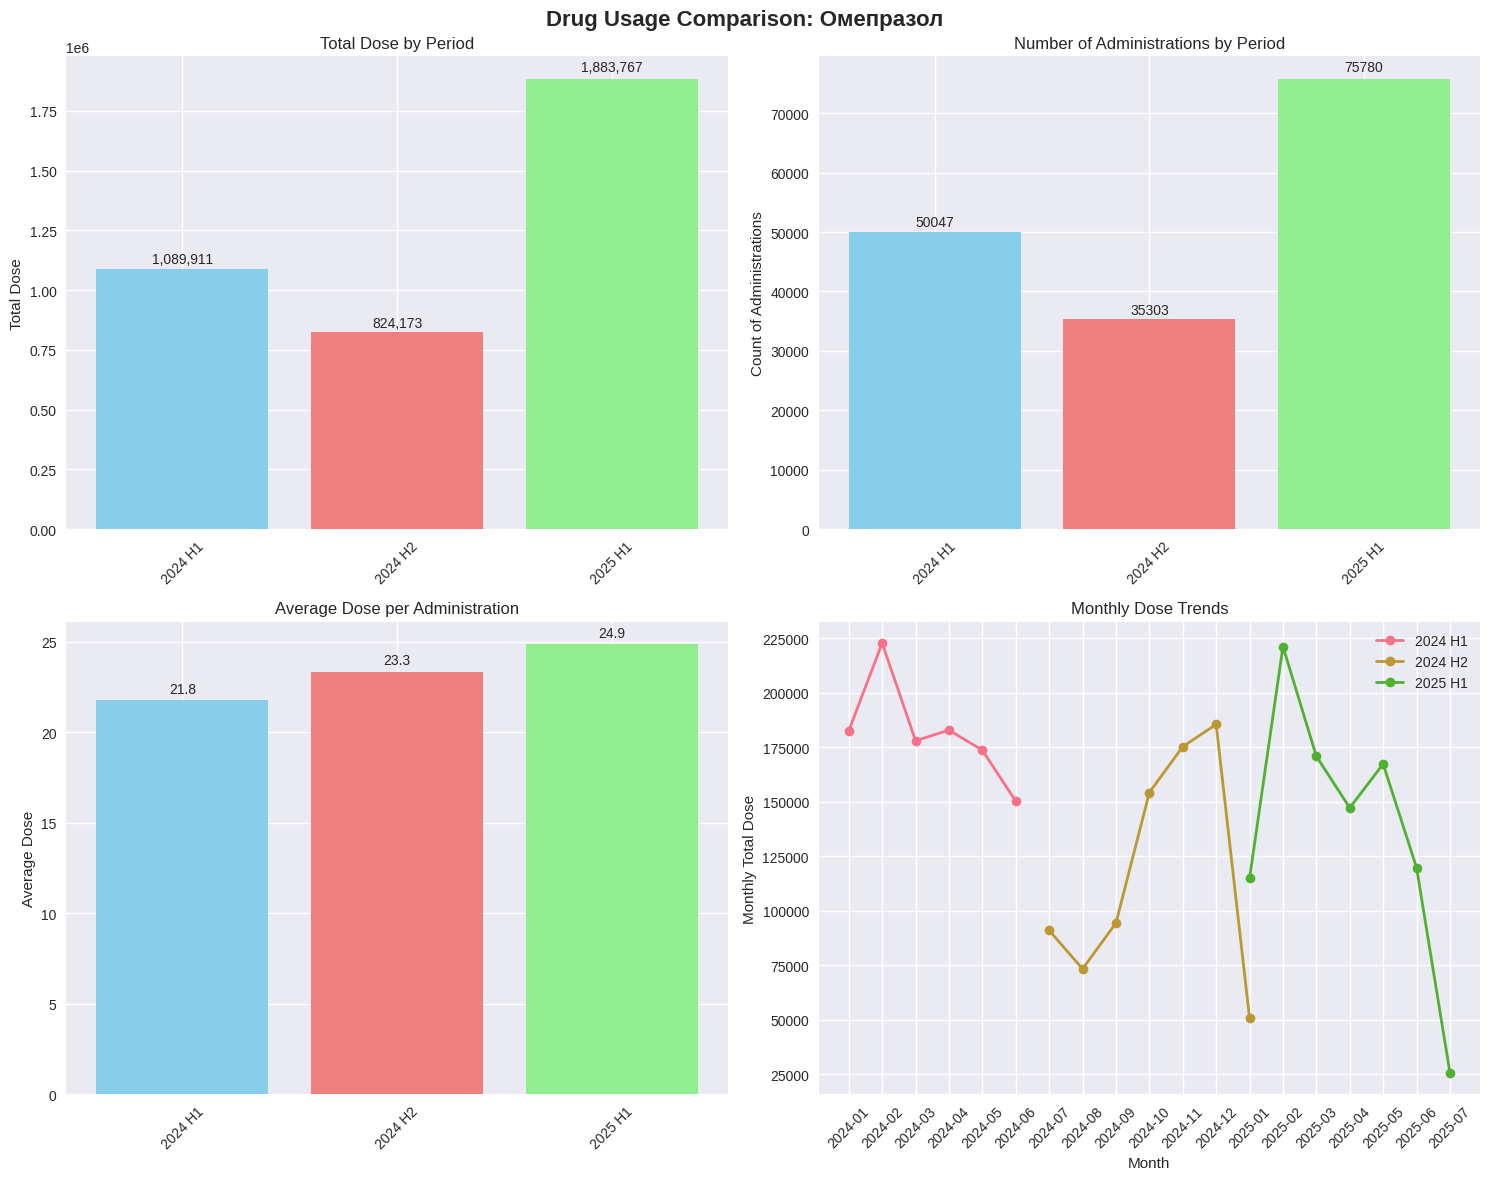


=== Summary for Омепразол ===
2024 H1: 50,047 administrations, 1,089,911 total dose
2024 H2: 35,303 administrations, 824,173 total dose
2025 H1: 75,780 administrations, 1,883,767 total dose

Concentrations used: [nan '-' '20' '0.9%' '5%']
Measures used: ['мг' 'мл' nan 'ЕД']


In [ ]:
fig = plot_drug_usage_comparison(
    drug_df_2024, event_df_2024,
    drug_df_2025, event_df_2025,
    "Омепразол"
)

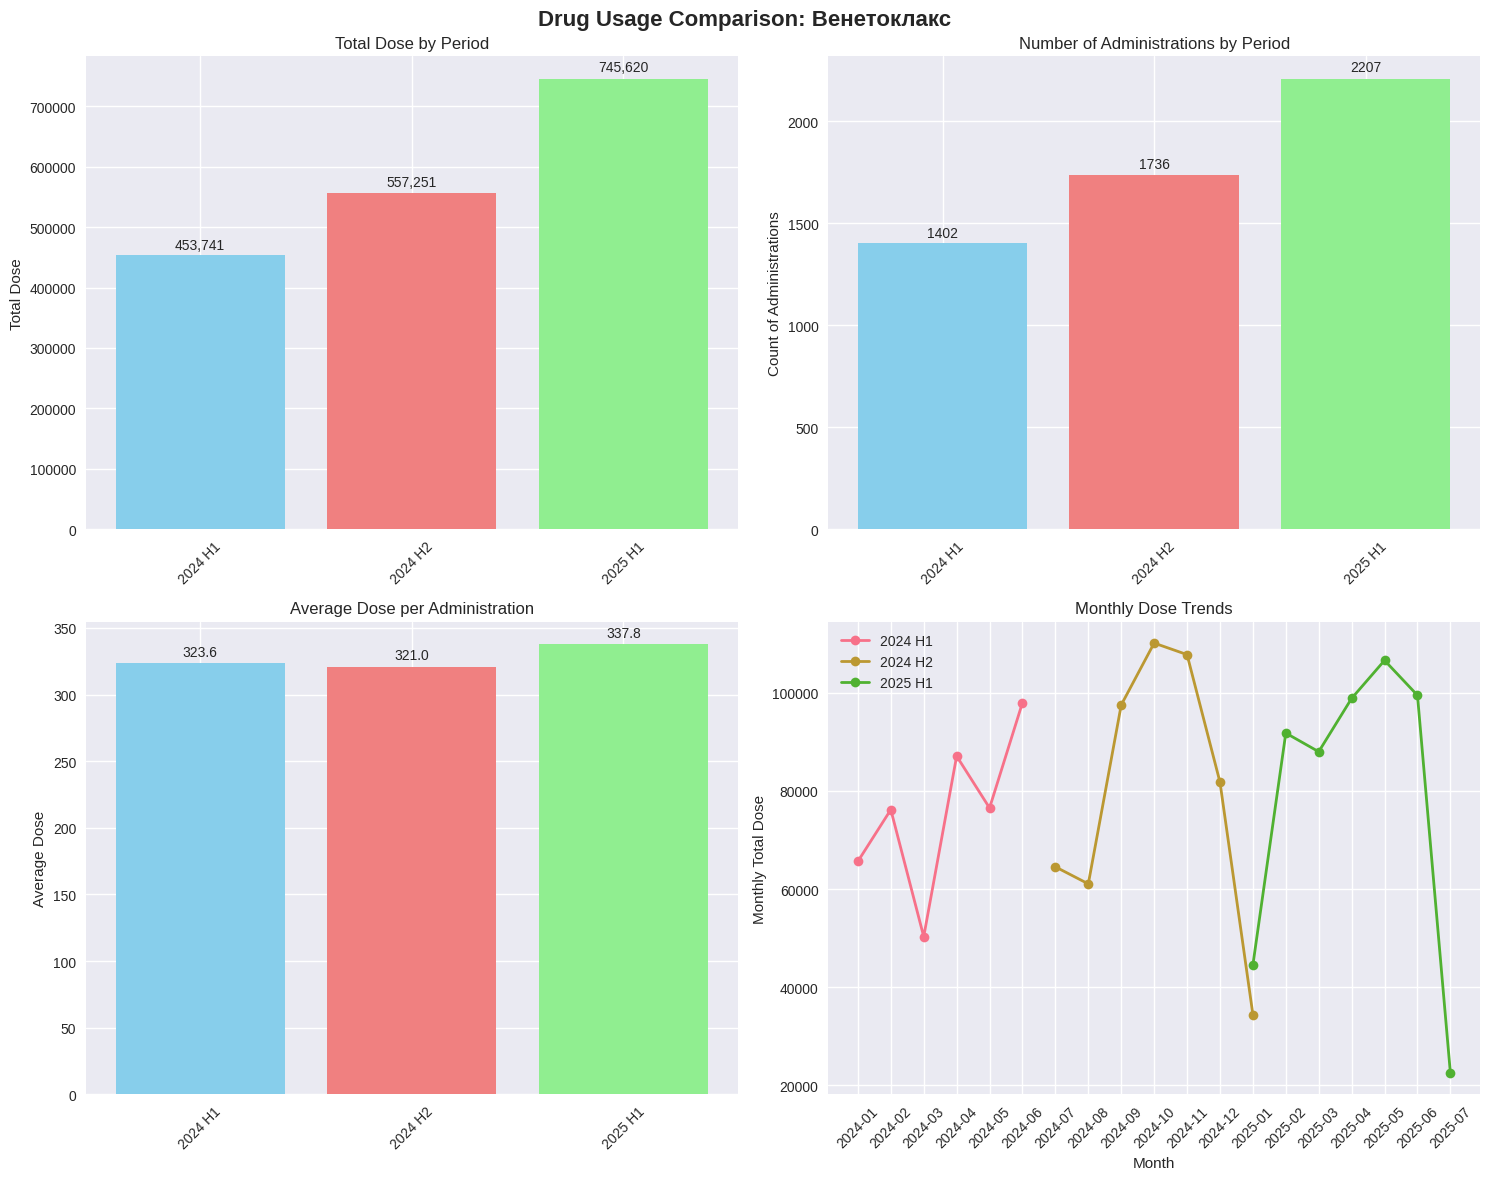


=== Summary for Венетоклакс ===
2024 H1: 1,402 administrations, 453,741 total dose
2024 H2: 1,736 administrations, 557,251 total dose
2025 H1: 2,207 administrations, 745,620 total dose

Concentrations used: [nan '-' '400']
Measures used: ['мг']


In [ ]:
fig = plot_drug_usage_comparison(
    drug_df_2024, event_df_2024,
    drug_df_2025, event_df_2025,
    "Венетоклакс"
)

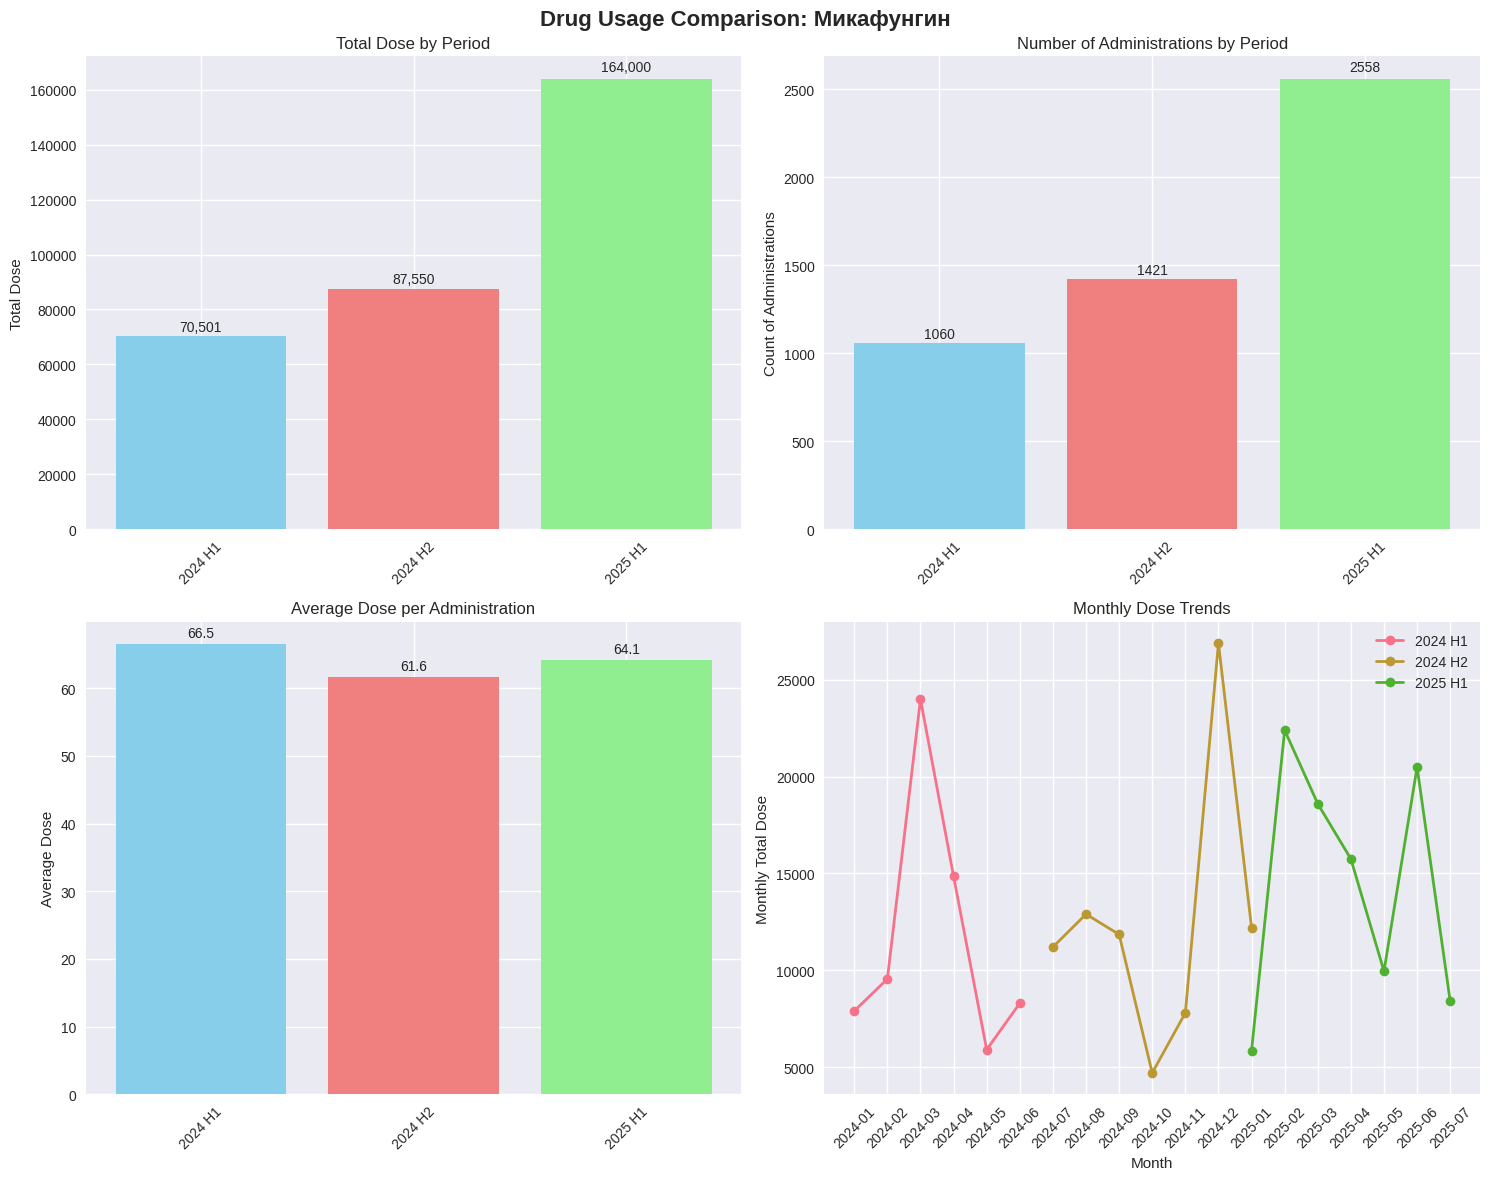


=== Summary for Микафунгин ===
2024 H1: 1,060 administrations, 70,501 total dose
2024 H2: 1,421 administrations, 87,550 total dose
2025 H1: 2,558 administrations, 164,000 total dose

Concentrations used: [nan '-' '0.9%']
Measures used: ['мг' 'мл' 'г']


In [ ]:
fig = plot_drug_usage_comparison(
    drug_df_2024, event_df_2024,
    drug_df_2025, event_df_2025,
    "Микафунгин"
)

In [ ]:
# Проверим даты в 2025 данных
print("Диапазон дат в drug_df_2025:")
print(f"Минимальная дата: {drug_df_2025['execution_date'].min()}")
print(f"Максимальная дата: {drug_df_2025['execution_date'].max()}")
print(f"Уникальные года: {drug_df_2025['execution_date'].dt.year.unique()}")

# И размеры
print(f"\nРазмер drug_df_2024: {len(drug_df_2024)}")
print(f"Размер drug_df_2025: {len(drug_df_2025)}")

# Проверим что в 2024 файле нет 2025 дат
print(f"\nУникальные года в drug_df_2024: {drug_df_2024['execution_date'].dt.year.unique()}")

Диапазон дат в drug_df_2025:
Минимальная дата: 2025-01-01 12:31:01+00:00
Максимальная дата: 2025-07-14 18:19:57+00:00
Уникальные года: [2025.   nan]

Размер drug_df_2024: 1742561
Размер drug_df_2025: 861516

Уникальные года в drug_df_2024: [  nan 2024. 2025.]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def plot_drug_trends_simple(drug_df_2024, drug_df_2025, drug_names, by_month=True):
    """
    Simple line plot showing drug administration trends

    Parameters:
    - drug_df_2024: DataFrame with 2024 drug data
    - drug_df_2025: DataFrame with 2025 drug data
    - drug_names: List of drug names to compare
    - by_month: If True, show monthly data. If False, show 3-point comparison (2024 H1, 2024 H2, 2025 H1)
    """

    # Convert execution_date to datetime
    drug_df_2024['execution_date'] = pd.to_datetime(drug_df_2024['execution_date'])
    drug_df_2025['execution_date'] = pd.to_datetime(drug_df_2025['execution_date'])

    plt.figure(figsize=(12, 6))

    if by_month:
        # Monthly view
        for drug_name in drug_names:
            # Get data for this drug
            drug_2024 = drug_df_2024[drug_df_2024['mnn'] == drug_name].copy()
            drug_2025 = drug_df_2025[drug_df_2025['mnn'] == drug_name].copy()

            if drug_2024.empty and drug_2025.empty:
                print(f"No data found for drug: {drug_name}")
                continue

            # Combine both years
            all_data = pd.concat([drug_2024, drug_2025])

            # Group by month and count administrations
            all_data['month'] = all_data['execution_date'].dt.to_period('M')
            monthly_counts = all_data.groupby('month').size().reset_index(name='count')

            # Convert period to string for plotting
            monthly_counts['month_str'] = monthly_counts['month'].astype(str)

            # Plot the line
            plt.plot(monthly_counts['month_str'], monthly_counts['count'],
                    marker='o', linewidth=2, markersize=6, label=drug_name)

        plt.title('Monthly Drug Administration Trends', fontsize=14, fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel('Number of Administrations')
        plt.xticks(rotation=45)

    else:
        # 3-point comparison (H1 2024, H2 2024, H1 2025)
        periods = ['2024 H1', '2024 H2', '2025 H1']

        for drug_name in drug_names:
            # Get data for this drug
            drug_2024 = drug_df_2024[drug_df_2024['mnn'] == drug_name].copy()
            drug_2025 = drug_df_2025[drug_df_2025['mnn'] == drug_name].copy()

            if drug_2024.empty and drug_2025.empty:
                print(f"No data found for drug: {drug_name}")
                continue

            # Split 2024 into halves
            drug_2024_h1 = drug_2024[drug_2024['execution_date'] < '2024-07-01']
            drug_2024_h2 = drug_2024[drug_2024['execution_date'] >= '2024-07-01']

            # Count administrations for each period
            counts = [
                len(drug_2024_h1),  # 2024 H1
                len(drug_2024_h2),  # 2024 H2
                len(drug_2025)      # 2025 H1
            ]

            # Plot the line
            plt.plot(periods, counts, marker='o', linewidth=2,
                    markersize=8, label=drug_name)

            # Add value labels on points
            for i, count in enumerate(counts):
                plt.annotate(f'{count}', (i, count),
                           textcoords="offset points", xytext=(0,10), ha='center')

        plt.title('Drug Administration Trends by Period', fontsize=14, fontweight='bold')
        plt.xlabel('Period')
        plt.ylabel('Number of Administrations')

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
# Option 1: 3-point comparison (simple dots connected by lines)
# plot_drug_trends_simple(drug_df_2024, drug_df_2025, ["DRUG1", "DRUG2", "DRUG3"], by_month=False)

# Option 2: Monthly trends
# plot_drug_trends_simple(drug_df_2024, drug_df_2025, ["DRUG1", "DRUG2", "DRUG3"], by_month=True)

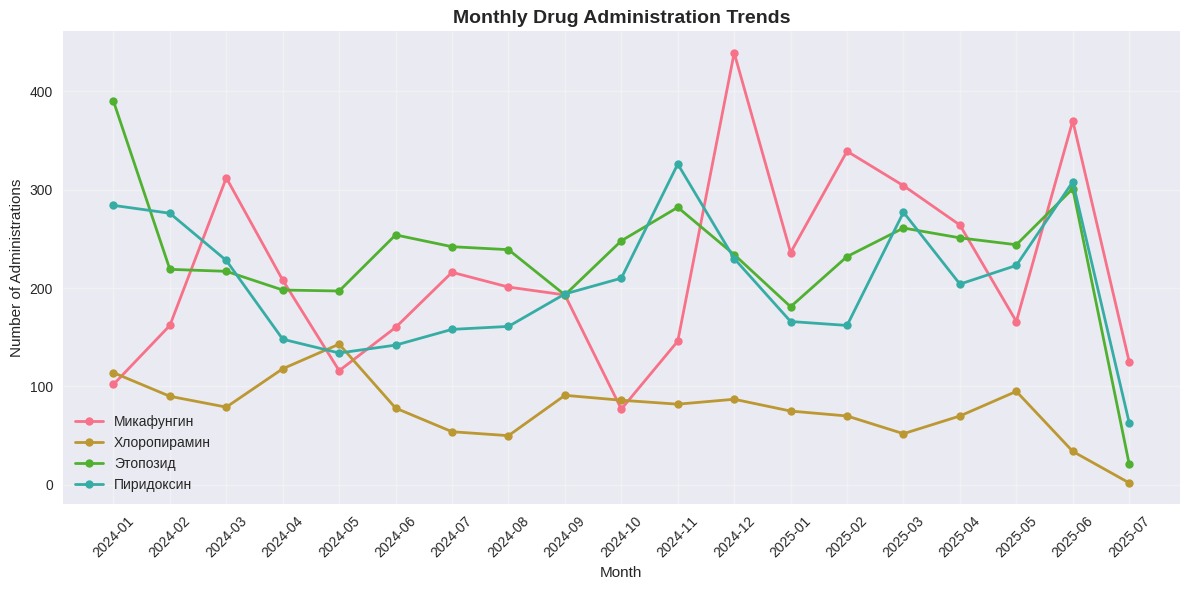

In [ ]:
plot_drug_trends_simple(drug_df_2024, drug_df_2025, ["Микафунгин", "Хлоропирамин", "Этопозид", "Пиридоксин"], by_month=True)

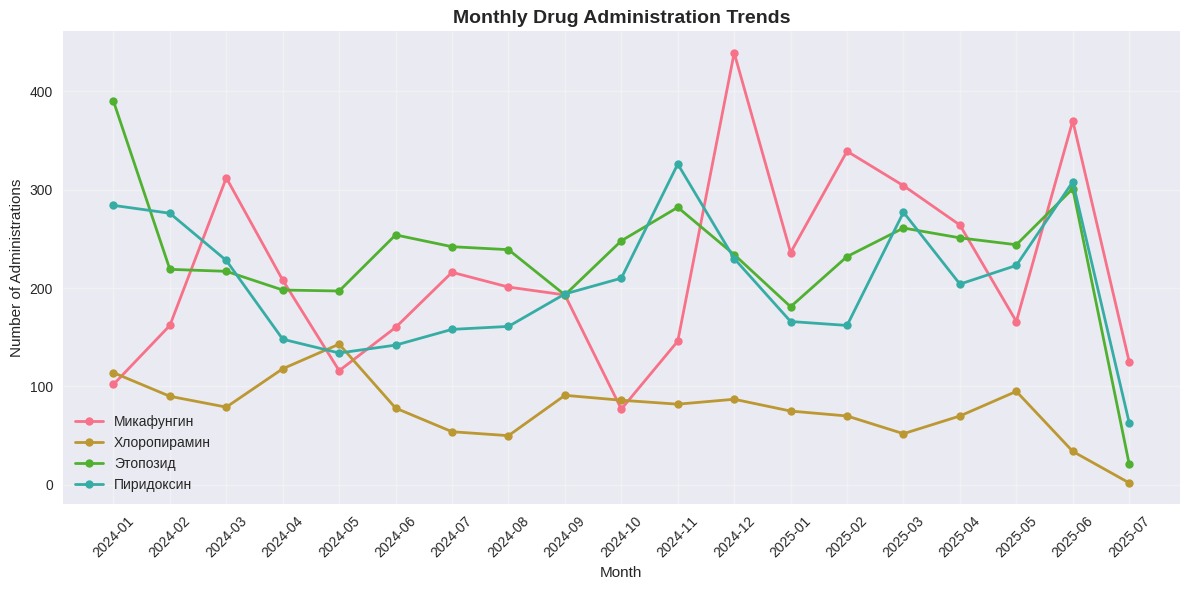

In [ ]:
plot_drug_trends_simple(drug_df_2024, drug_df_2025, ["Микафунгин", "Хлоропирамин", "Этопозид", "Пиридоксин"], by_month=True)